In [478]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [479]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [480]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.8
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 4800
Test set size: 1200


In [481]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])
    
test_t_x_data = np.zeros(len(test_RO_timestamps))

for i in range(len(test_RO_timestamps)):
    test_t_x_data[i] = test_RO_se3s[i][0,3]

In [482]:
dim1_data = t_x_data
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()

In [536]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# sc = MinMaxScaler()
# training_data = sc.fit_transform(training_set)

training_data = dim1_data_scaled.reshape(-1,1)

seq_length = 10
x, y = sliding_windows(training_data, seq_length)

train_test_ratio = 0.8
train_size = int(len(y) * train_test_ratio)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("dataX:",dataX.shape)
print("trainX:",trainX.shape)
print("testX:",testX.shape)

dataX: torch.Size([4789, 10, 1])
trainX: torch.Size([3831, 10, 1])
testX: torch.Size([958, 10, 1])


In [537]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # hidden and cell states
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Debugging
#         print("x",x.shape,"\n",x)
#         print("h_0",h_0.shape,"\n",h_0)
#         print("c_0",c_0.shape,"\n",c_0)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [538]:
num_epochs = 500
learning_rate = 0.01

input_size = 1
hidden_size = 20
num_layers = 1

lstm = LSTM(input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
#     print("training x shape:",trainX.shape)
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.96371
Epoch: 50, loss: 0.01047
Epoch: 100, loss: 0.00609
Epoch: 150, loss: 0.00582
Epoch: 200, loss: 0.00573
Epoch: 250, loss: 0.00567
Epoch: 300, loss: 0.00562
Epoch: 350, loss: 0.00559
Epoch: 400, loss: 0.00555
Epoch: 450, loss: 0.00552


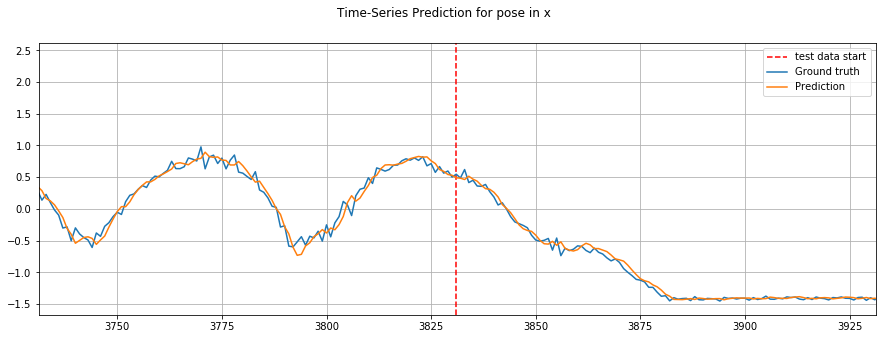

In [539]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
view_size = 100
plt.xlim(len(dataY)*train_test_ratio-view_size,len(dataY)*train_test_ratio+view_size)
plt.plot(dataY_plot,label="Ground truth")
plt.plot(data_predict,label="Prediction")
plt.suptitle('Time-Series Prediction for pose in x')
plt.grid()
plt.legend()
plt.show()

In [540]:
def appender(subseq,new_val):
    """
    Append value to input sequence (treat as arrays)
    """
#     print(subseq)
#     print(new_val)
    subseq = np.delete(subseq,0)
    new_subseq = np.append(subseq,new_val)
    
#     subseq = subseq.reshape(-1,1)
#     new_subseq = Variable(torch.tensor(subseq))
#     new_subseq = new_subseq[np.newaxis,...]
#     print("new subseq:",new_subseq)
    return new_subseq

data size and type: torch.Size([4789, 10, 1]) <class 'torch.Tensor'>


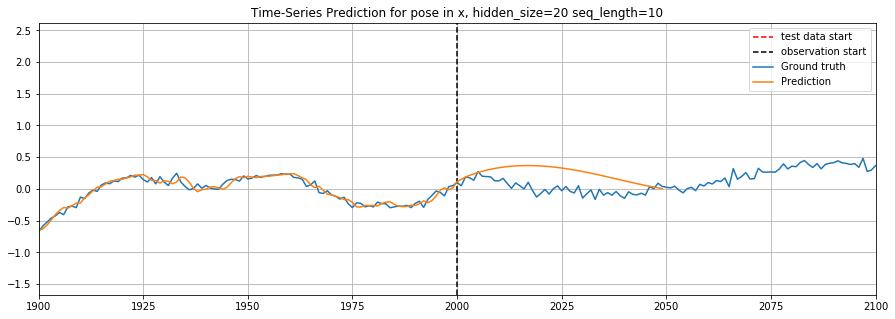

In [541]:
print("data size and type:",dataX.size(),type(dataX))

prediction_start_index = 2000
subseq = trainX[prediction_start_index]
future_val = trainY.data.numpy()[prediction_start_index][0]

lstm.eval()
output_collection = lstm(trainX[:prediction_start_index])

for i in range(50):
    new_subseq = appender(subseq,future_val)
    new_subseq = new_subseq[np.newaxis,...,np.newaxis]
    new_subseq = Variable(torch.tensor(new_subseq))
#     print("data size and type:",new_subseq.size(),type(new_subseq))

    next_prediction = lstm(new_subseq)
    output_collection = torch.cat((output_collection, next_prediction), 0)

    # Update states
    subseq = new_subseq
    future_val = next_prediction.data.numpy()
    
predictions = output_collection

data_predict = predictions.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="observation start")
view_size = 100
x_centre = prediction_start_index #len(dataY)*train_test_ratio
plt.xlim(x_centre-view_size,x_centre+view_size)
plt.plot(dataY_plot,label="Ground truth")
plt.plot(data_predict,label="Prediction")
title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
             +' seq_length='+str(seq_length)
plt.title(title_string)
plt.grid()
plt.legend()

In [542]:
save_plots = True
if save_plots:
    for frame in range(prediction_start_index,prediction_start_index+100):
        prediction_start_index = frame
        subseq = trainX[prediction_start_index]
        future_val = trainY.data.numpy()[prediction_start_index][0]

        lstm.eval()
        output_collection = lstm(trainX[:prediction_start_index])

        for i in range(50):
            new_subseq = appender_tmp(subseq,future_val)
            new_subseq = new_subseq[np.newaxis,...,np.newaxis]
            new_subseq = Variable(torch.tensor(new_subseq))
        #     print("data size and type:",new_subseq.size(),type(new_subseq))

            next_prediction = lstm(new_subseq)
            output_collection = torch.cat((output_collection, next_prediction), 0)

            # Update states
            subseq = new_subseq
            future_val = next_prediction.data.numpy()

        predictions = output_collection

        data_predict = predictions.data.numpy()
        dataY_plot = dataY.data.numpy()

        fig = plt.figure(figsize=(15,5))
        plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
        plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="observation start")
        view_size = 100
        x_centre = prediction_start_index #len(dataY)*train_test_ratio
        plt.xlim(x_centre-view_size,x_centre+view_size)
        plt.plot(dataY_plot,label="Ground truth")
        plt.plot(data_predict,label="Prediction")
        title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
                     +' seq_length='+str(seq_length)
        plt.title(title_string)
        plt.grid()
        plt.legend()
        plt.savefig("%s%i%s%i%s" % ('/workspace/data/pose-prediction-odometry/predictions-x/hiddensize-',hidden_size,'-frame-',frame,'.png'), \
                    bbox_inches='tight')
        plt.close(fig)

toy_Y_data: [0.  0.1 0.2 0.3 0.4]


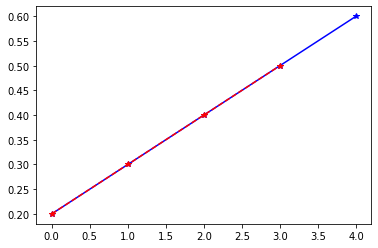

In [772]:
# Constant velocity predictor
def constant_velocity_prediction(x_t0, x_tm1):
    delta_x = x_t0 - x_tm1
    x_tp1 = x_t0 + delta_x
    return x_tp1

def first_diff_prediction_poly(x_t0,x_tm1,horizon):
    x = np.linspace(0,1,2)
    y = np.array([x_tm1,x_t0])
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    xp = np.linspace(0, horizon, horizon+1)
#     print("x:",x)
#     print("y:",y)
#     print("xp:",xp)
    return p(xp)

toy_Y_data = np.linspace(0,0.4,5)
print("toy_Y_data:",toy_Y_data)

x_t0 = toy_Y_data[1] #dataY[1].data.numpy()
x_tm1 = toy_Y_data[0] #dataY[0].data.numpy()

x_values = np.empty(5)
for i in range(len(x_values)):
    x_tp1 = constant_velocity_prediction(x_t0,x_tm1)
    x_values[i] = x_tp1
    x_tm1 = x_t0
    x_t0 = x_tp1
    
plt.plot(x_values,'b*-')

x_t0 = toy_Y_data[1] #dataY[1].data.numpy()
x_tm1 = toy_Y_data[0] #dataY[0].data.numpy()

poly_x_vals = first_diff_prediction_poly(float(x_t0),float(x_tm1),5)
plt.plot(poly_x_vals[2:],'r*--')# crop off the inputs as they are otherwise included in this output


data size and type: torch.Size([4789, 10, 1]) <class 'torch.Tensor'>
x: [0. 1.]
y: [-1.30423701 -1.19813371]
xp: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


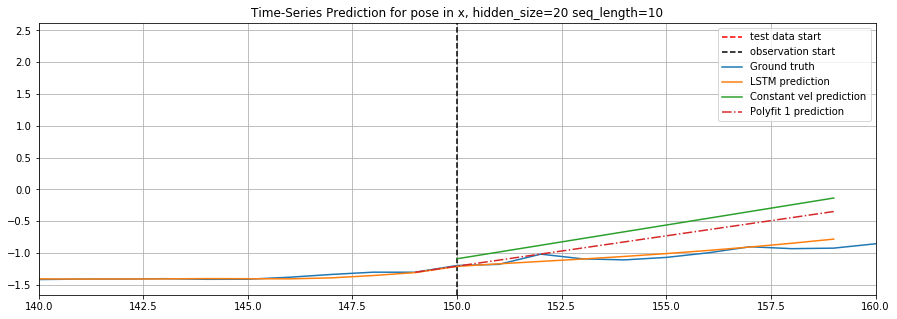

In [752]:
print("data size and type:",dataX.size(),type(dataX))

prediction_start_index = 150
prediction_horizon = 10
subseq = trainX[prediction_start_index]
future_val = trainY.data.numpy()[prediction_start_index][0]

x_t0 = dataY[prediction_start_index].data.numpy()
x_tm1 = dataY[prediction_start_index-1].data.numpy()
constant_velocity_predictions = np.zeros(prediction_horizon)

lstm.eval()
output_collection = lstm(trainX[:prediction_start_index])

# polyfit predictions
poly_x_vals = first_diff_prediction_poly(float(x_t0),float(x_tm1),prediction_horizon-1)

for i in range(prediction_horizon):
    new_subseq = appender(subseq,future_val)
    new_subseq = new_subseq[np.newaxis,...,np.newaxis]
    new_subseq = Variable(torch.tensor(new_subseq))
#     print("data size and type:",new_subseq.size(),type(new_subseq))

    next_prediction = lstm(new_subseq)
    output_collection = torch.cat((output_collection, next_prediction), 0)

    # Update states
    subseq = new_subseq
    future_val = next_prediction.data.numpy()
    
    # constant velocity predictions
    x_tp1 = constant_velocity_prediction(x_t0,x_tm1)
    constant_velocity_predictions[i] = x_tp1
    x_tm1 = x_t0
    x_t0 = x_tp1
    
predictions = output_collection

data_predict = predictions.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="observation start")
view_size = prediction_horizon
x_centre = prediction_start_index #len(dataY)*train_test_ratio
plt.xlim(x_centre-view_size,x_centre+view_size)
plt.plot(dataY_plot,label="Ground truth")
plt.plot(data_predict,label="LSTM prediction")
plt.plot(np.linspace(prediction_start_index,prediction_start_index+i,prediction_horizon),constant_velocity_predictions,label="Constant vel prediction")
plt.plot(np.linspace(prediction_start_index-1,prediction_start_index+i,prediction_horizon),poly_x_vals,'-.',label="Polyfit 1 prediction")
title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
             +' seq_length='+str(seq_length)
plt.title(title_string)
plt.grid()
plt.legend()

In [594]:
save_plots = True
if save_plots:
    for frame in range(prediction_start_index,prediction_start_index+100):
        prediction_start_index = frame
        prediction_horizon = 50
        subseq = trainX[prediction_start_index]
        future_val = trainY.data.numpy()[prediction_start_index][0]
        
        x_t0 = dataY[prediction_start_index].data.numpy()
        x_tm1 = dataY[prediction_start_index-1].data.numpy()
        constant_velocity_predictions = np.zeros(prediction_horizon)

        lstm.eval()
        output_collection = lstm(trainX[:prediction_start_index])

        for i in range(50):
            new_subseq = appender_tmp(subseq,future_val)
            new_subseq = new_subseq[np.newaxis,...,np.newaxis]
            new_subseq = Variable(torch.tensor(new_subseq))
        #     print("data size and type:",new_subseq.size(),type(new_subseq))

            next_prediction = lstm(new_subseq)
            output_collection = torch.cat((output_collection, next_prediction), 0)

            # Update states
            subseq = new_subseq
            future_val = next_prediction.data.numpy()
            
            # constant velocity predictions
            x_tp1 = constant_velocity_prediction(x_t0,x_tm1)
            constant_velocity_predictions[i] = x_tp1
            x_tm1 = x_t0
            x_t0 = x_tp1

        predictions = output_collection

        data_predict = predictions.data.numpy()
        dataY_plot = dataY.data.numpy()

        fig = plt.figure(figsize=(15,5))
        plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
        plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="observation start")
        view_size = 100
        x_centre = prediction_start_index #len(dataY)*train_test_ratio
        plt.xlim(x_centre-view_size,x_centre+view_size)
        plt.ylim(-2,3)
        plt.plot(dataY_plot,label="Ground truth")
        plt.plot(data_predict,label="LSTM prediction")
        plt.plot(np.linspace(prediction_start_index,prediction_start_index+i),constant_velocity_predictions,label="Constant vel prediction")
        title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
                     +' seq_length='+str(seq_length)
        plt.title(title_string)
        plt.grid()
        plt.legend()
        plt.savefig("%s%i%s%i%s" % ('/workspace/data/pose-prediction-odometry/predictions-x/hiddensize-',hidden_size,'-frame-',frame,'.png'), \
                    bbox_inches='tight')
        plt.close(fig)

[-1.42635179 -1.44177735 -1.4630425  -1.49014723 -1.52309155]


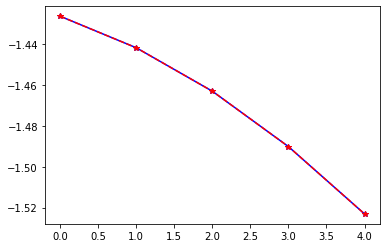

In [776]:
# Constant velocity predictor
def second_diff_prediction(x_t0, x_tm1,x_tm2):
    delta_1 = x_tm1 - x_tm2
    delta_2 = x_t0 - x_tm1
    second_diff_delta = delta_2 - delta_1
    x_tp1 = x_t0 + delta_2 + second_diff_delta
    return x_tp1

def second_diff_prediction_poly(x_t0,x_tm1,x_tm2,horizon):
    x = np.linspace(0,2,3)
    y = np.array([x_tm2,x_tm1,x_t0])
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    xp = np.linspace(0, horizon, horizon+1)  
    return p(xp)

def third_diff_prediction_poly(x_t0,x_tm1,x_tm2,x_tm3,horizon):
    x = np.linspace(0,3,4)
    y = np.array([x_tm3,x_tm2,x_tm1,x_t0])
    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    xp = np.linspace(0, horizon, horizon+1)  
    return p(xp)

x_t0 = dataY[2].data.numpy()
x_tm1 = dataY[1].data.numpy()
x_tm2 = dataY[0].data.numpy()

x_values = np.empty(5)
for i in range(len(x_values)):
    x_tp1 = second_diff_prediction(x_t0,x_tm1,x_tm2)
    x_values[i] = x_tp1
    x_tm2 = x_tm1
    x_tm1 = x_t0
    x_t0 = x_tp1
    
print(x_values)
plt.plot(x_values,'b*-')

x_t0 = dataY[2].data.numpy()
x_tm1 = dataY[1].data.numpy()
x_tm2 = dataY[0].data.numpy()
poly_x_vals = second_diff_prediction_poly(float(x_t0),float(x_tm1),float(x_tm2),7)
plt.plot(poly_x_vals[3:],'r*--') # crop off the inputs as they are otherwise included in this output

data size and type: torch.Size([4789, 10, 1]) <class 'torch.Tensor'>
x: [0. 1.]
y: [-1.30423701 -1.19813371]
xp: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49.]


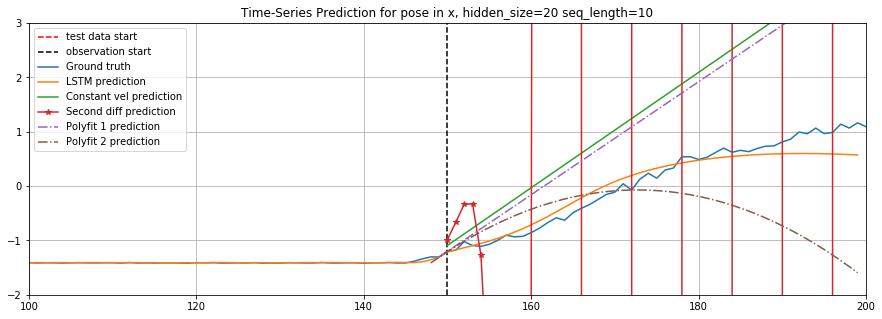

In [770]:
print("data size and type:",dataX.size(),type(dataX))

prediction_start_index = 150
prediction_horizon = 50
subseq = trainX[prediction_start_index]
future_val = trainY.data.numpy()[prediction_start_index][0]

x_t0 = dataY[prediction_start_index].data.numpy()
x_tm1 = dataY[prediction_start_index-1].data.numpy()

poly_1st_vals = first_diff_prediction_poly(float(x_t0),float(x_tm1),prediction_horizon-1)
poly_2nd_vals = second_diff_prediction_poly(float(x_t0),float(x_tm1),float(x_tm2),prediction_horizon-1)

second_diff_x_t0 = dataY[prediction_start_index].data.numpy()
second_diff_x_tm1 = dataY[prediction_start_index-1].data.numpy()
second_diff_x_tm2 = dataY[prediction_start_index-2].data.numpy()

constant_velocity_predictions = np.zeros(prediction_horizon)
second_diff_predictions = np.zeros(prediction_horizon)

lstm.eval()
output_collection = lstm(trainX[:prediction_start_index])

for i in range(prediction_horizon):
    new_subseq = appender(subseq,future_val)
    new_subseq = new_subseq[np.newaxis,...,np.newaxis]
    new_subseq = Variable(torch.tensor(new_subseq))
#     print("data size and type:",new_subseq.size(),type(new_subseq))

    next_prediction = lstm(new_subseq)
    output_collection = torch.cat((output_collection, next_prediction), 0)

    # Update states
    subseq = new_subseq
    future_val = next_prediction.data.numpy()
    
    # constant velocity predictions
    x_tp1 = constant_velocity_prediction(x_t0,x_tm1)
    constant_velocity_predictions[i] = x_tp1
    x_tm1 = x_t0
    x_t0 = x_tp1
    
    # second diff predictions
    second_diff_x_tp1 = second_diff_prediction(second_diff_x_t0,second_diff_x_tm1,second_diff_x_tm2)
    second_diff_predictions[i] = second_diff_x_tp1
    second_diff_x_tm1 = second_diff_x_t0
    second_diff_x_t0 = second_diff_x_tp1
    
predictions = output_collection

data_predict = predictions.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="observation start")
view_size = prediction_horizon
x_centre = prediction_start_index #len(dataY)*train_test_ratio
plt.xlim(x_centre-view_size,x_centre+view_size)
plt.ylim(-2,3)
plt.plot(dataY_plot,label="Ground truth")
plt.plot(data_predict,label="LSTM prediction")
plt.plot(np.linspace(prediction_start_index,prediction_start_index+i,prediction_horizon),constant_velocity_predictions,label="Constant vel prediction")
plt.plot(np.linspace(prediction_start_index,prediction_start_index+i,prediction_horizon),second_diff_predictions,'-*',label="Second diff prediction")
plt.plot(np.linspace(prediction_start_index-1,prediction_start_index+i,prediction_horizon),poly_1st_vals,'-.',label="Polyfit 1 prediction")
plt.plot(np.linspace(prediction_start_index-2,prediction_start_index+i,prediction_horizon),poly_2nd_vals,'-.',label="Polyfit 2 prediction")
title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
             +' seq_length='+str(seq_length)
plt.title(title_string)
plt.grid()
plt.legend()

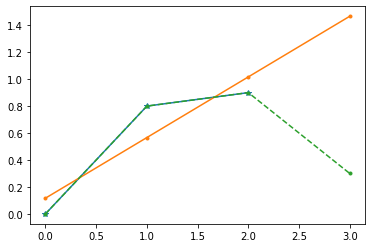

In [768]:
x = np.linspace(0,2,3)
y = np.array([0.0, 0.8, 0.9])
z = np.polyfit(x, y, 1)
z
p = np.poly1d(z)

p30 = np.poly1d(np.polyfit(x, y, 2))

xp = np.linspace(0, 3, 4)
plt.plot(x, y, '*-', xp, p(xp), '.-', xp, p30(xp), '.--')

plt.show()

data size and type: torch.Size([4789, 10, 1]) <class 'torch.Tensor'>


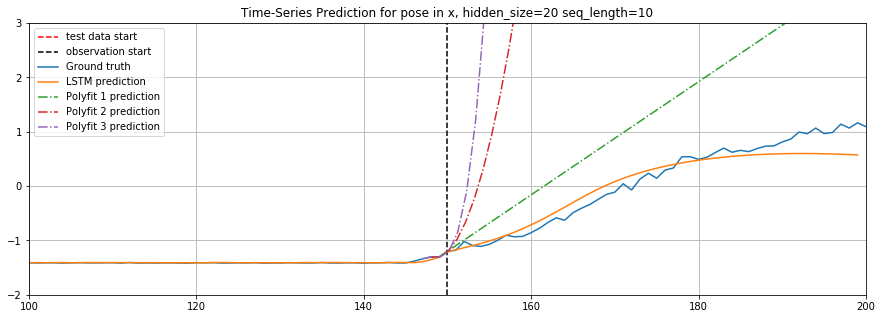

In [781]:
print("data size and type:",dataX.size(),type(dataX))

prediction_start_index = 150
prediction_horizon = 50
subseq = trainX[prediction_start_index]
future_val = trainY.data.numpy()[prediction_start_index][0]

x_t0 = dataY[prediction_start_index].data.numpy()
x_tm1 = dataY[prediction_start_index-1].data.numpy()
x_tm2 = dataY[prediction_start_index-2].data.numpy()
x_tm3 = dataY[prediction_start_index-3].data.numpy()

poly_1st_vals = first_diff_prediction_poly(float(x_t0),float(x_tm1),prediction_horizon-1)
poly_2nd_vals = second_diff_prediction_poly(float(x_t0),float(x_tm1),float(x_tm2),prediction_horizon-1)
poly_3rd_vals = third_diff_prediction_poly(float(x_t0),float(x_tm1),float(x_tm2),float(x_tm3),prediction_horizon-1)

lstm.eval()
output_collection = lstm(trainX[:prediction_start_index])

for i in range(prediction_horizon):
    new_subseq = appender(subseq,future_val)
    new_subseq = new_subseq[np.newaxis,...,np.newaxis]
    new_subseq = Variable(torch.tensor(new_subseq))

    next_prediction = lstm(new_subseq)
    output_collection = torch.cat((output_collection, next_prediction), 0)

    # Update states
    subseq = new_subseq
    future_val = next_prediction.data.numpy()
    
predictions = output_collection

data_predict = predictions.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="observation start")
view_size = prediction_horizon
x_centre = prediction_start_index #len(dataY)*train_test_ratio
plt.xlim(x_centre-view_size,x_centre+view_size)
plt.ylim(-2,3)
plt.plot(dataY_plot,label="Ground truth")
plt.plot(data_predict,label="LSTM prediction")
plt.plot(np.linspace(prediction_start_index-1,prediction_start_index+i,prediction_horizon),poly_1st_vals,'-.',label="Polyfit 1 prediction")
plt.plot(np.linspace(prediction_start_index-2,prediction_start_index+i,prediction_horizon),poly_2nd_vals,'-.',label="Polyfit 2 prediction")
plt.plot(np.linspace(prediction_start_index-3,prediction_start_index+i,prediction_horizon),poly_3rd_vals,'-.',label="Polyfit 3 prediction")

title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
             +' seq_length='+str(seq_length)
plt.title(title_string)
plt.grid()
plt.legend()

In [783]:
save_plots = True
prediction_start_index = 140
if save_plots:
    for frame in range(prediction_start_index,prediction_start_index+200):
        prediction_start_index = frame
        prediction_horizon = 50
        subseq = trainX[prediction_start_index]
        future_val = trainY.data.numpy()[prediction_start_index][0]
        
        x_t0 = dataY[prediction_start_index].data.numpy()
        x_tm1 = dataY[prediction_start_index-1].data.numpy()
        x_tm2 = dataY[prediction_start_index-2].data.numpy()
        x_tm3 = dataY[prediction_start_index-3].data.numpy()
        
        poly_1st_vals = first_diff_prediction_poly(float(x_t0),float(x_tm1),prediction_horizon-1)
        poly_2nd_vals = second_diff_prediction_poly(float(x_t0),float(x_tm1),float(x_tm2),prediction_horizon-1)
        poly_3rd_vals = third_diff_prediction_poly(float(x_t0),float(x_tm1),float(x_tm2),float(x_tm3),prediction_horizon-1)


        lstm.eval()
        output_collection = lstm(trainX[:prediction_start_index])

        for i in range(50):
            new_subseq = appender_tmp(subseq,future_val)
            new_subseq = new_subseq[np.newaxis,...,np.newaxis]
            new_subseq = Variable(torch.tensor(new_subseq))

            next_prediction = lstm(new_subseq)
            output_collection = torch.cat((output_collection, next_prediction), 0)

            # Update states
            subseq = new_subseq
            future_val = next_prediction.data.numpy()
           
        predictions = output_collection

        data_predict = predictions.data.numpy()
        dataY_plot = dataY.data.numpy()

        fig = plt.figure(figsize=(15,5))
        plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
        plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="observation start")
        view_size = 100
        x_centre = prediction_start_index #len(dataY)*train_test_ratio
        plt.xlim(x_centre-view_size,x_centre+view_size)
        plt.ylim(-2,3)
        plt.plot(dataY_plot,label="Ground truth")
        plt.plot(data_predict,label="LSTM prediction")
        plt.plot(np.linspace(prediction_start_index-1,prediction_start_index+i,prediction_horizon),poly_1st_vals,'-.',label="Polyfit 1 prediction")
        plt.plot(np.linspace(prediction_start_index-2,prediction_start_index+i,prediction_horizon),poly_2nd_vals,'-.',label="Polyfit 2 prediction")
        plt.plot(np.linspace(prediction_start_index-3,prediction_start_index+i,prediction_horizon),poly_3rd_vals,'-.',label="Polyfit 3 prediction")
        title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
                     +' seq_length='+str(seq_length)
        plt.title(title_string)
        plt.grid()
        plt.legend()
        plt.savefig("%s%i%s%i%s" % ('/workspace/data/pose-prediction-odometry/predictions-x/hiddensize-',hidden_size,'-frame-',frame,'.png'), \
                    bbox_inches='tight')
        plt.close(fig)